In [1]:
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

from sklearn.model_selection import train_test_split

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")
data_dir = root_dir / "Data"
model_dir = root_dir / "Logs"
saved_model_dir = root_dir / "SavedModel"
log_file = model_dir / "current_training.log"

# Import the configuration associated with this dataset and network.
params = maskflow.load_parameters(root_dir / "parameters.yml")

env: CUDA_VISIBLE_DEVICES=0


# Check Dataset

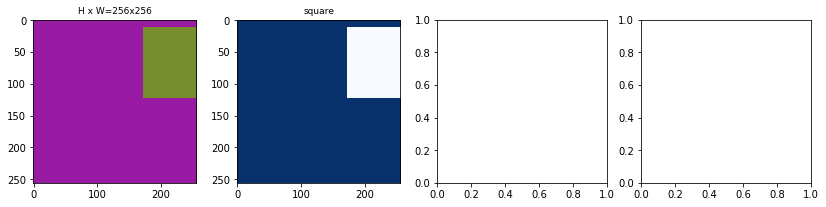

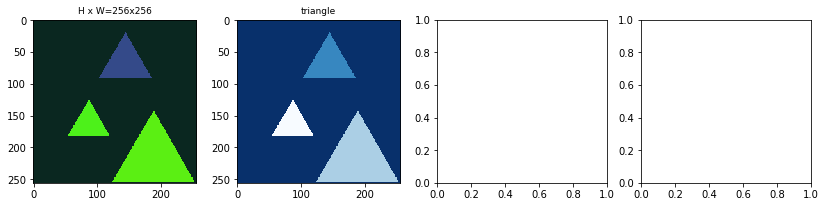

In [2]:
tfrecord_train = data_dir / "training_data.tfrecord"
tfrecord_evaluation = data_dir / "evaluation_data.tfrecord"

# Retrieve some data
images, annotations = maskflow.get_data(tfrecord_train, n=2, shuffle=True)

# Display them
maskflow.batch_display_top_masks(images, annotations["masks"], annotations["class_ids"], params["CLASS_NAMES"], limit=3)

# Training

In [12]:
batch_size = 2
num_epochs = 10

train_dataset = maskflow.build_dataset(tfrecord_train, batch_size=batch_size, num_epochs=num_epochs, shuffle=True)
eval_dataset = maskflow.build_dataset(tfrecord_evaluation, batch_size=batch_size, num_epochs=num_epochs, shuffle=False)

In [3]:
import torch

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.solver import make_lr_scheduler
from maskrcnn_benchmark.solver import make_optimizer
from maskrcnn_benchmark.engine.inference import inference
from maskrcnn_benchmark.engine.trainer import do_train
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.utils.collect_env import collect_env_info
from maskrcnn_benchmark.utils.comm import synchronize
from maskrcnn_benchmark.utils.imports import import_file
from maskrcnn_benchmark.utils.logger import setup_logger
from maskrcnn_benchmark.utils.miscellaneous import mkdir

In [4]:
distributed = False
local_rank = 0

config.OUTPUT_DIR = str(root_dir)
config.DATA_DIR = str(data_dir)

In [7]:
model = build_detection_model(config)
device = torch.device(config.MODEL.DEVICE)
model.to(device)

optimizer = make_optimizer(config, model)
scheduler = make_lr_scheduler(config, optimizer)

if distributed:
    torch.cuda.set_device(local_rank)
    model = torch.nn.parallel.deprecated.DistributedDataParallel(
        model, device_ids=[local_rank], output_device=local_rank,
        # this should be removed if we update BatchNorm stats
        broadcast_buffers=False,
    )
    
arguments = {}
arguments["iteration"] = 0

save_to_disk = local_rank == 0
checkpointer = DetectronCheckpointer(
    config, model, optimizer, scheduler, config.OUTPUT_DIR , save_to_disk
)
extra_checkpoint_data = checkpointer.load(config.MODEL.WEIGHT)
arguments.update(extra_checkpoint_data)

checkpoint_period = config.SOLVER.CHECKPOINT_PERIOD

data_loader = make_data_loader(config, is_train=True, is_distributed=distributed, start_iter=0)

In [8]:
do_train(
    model,
    data_loader,
    optimizer,
    scheduler,
    checkpointer,
    device,
    checkpoint_period,
    arguments)

RuntimeError: copy_if failed to synchronize: device-side assert triggered